In [1]:
import pandas as pd
import numpy as np
import regex as re
import igraph as ig
import sys
from pytictoc import TicToc
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import itertools
from itertools import chain
import pickle
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import mean_absolute_error
from torch_geometric.nn import GNNExplainer
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.model_selection import StratifiedKFold, train_test_split
import verstack
from verstack.stratified_continuous_split import scsplit
from pytorch_metric_learning import miners, losses
from pytorch_metric_learning.distances import SNRDistance, CosineSimilarity
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning.reducers import ThresholdReducer
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, GATConv, LEConv, GraphConv, MFConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gadp, global_sort_pool as gsp
from torch_geometric.nn import Set2Set as s2s

In [ ]:
time = TicToc()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
file_to_read = open("data/PyGO_vector_NNprepared.pickle", "rb")
dpyg_y = pickle.load(file_to_read)
vectordf = pd.read_csv("data/vectorDF.csv")

In [9]:
vectordf.columns

Index(['rtime', 'maxPath', 'numEdges', 'numNodes', 'avgShorPath', 'longPath',
       'numCliques', 'sumCent', 'maxDegree', 'att1_maxDeg', 'att2_maxDeg',
       'att3_maxDeg', 'avgNodeDegree', 'avgInsNum', 'avgPlanCpu', 'avgPlanMem',
       'sumInsNum', 'sumPlanCpu', 'sumPlanMem', 'maxInsNum', 'maxPlanCpu',
       'maxPlanMem', 'job_name'],
      dtype='object')

In [10]:
vectordf.columns.get_loc("sumPlanMem")

18

In [12]:
#stratified splitting
train, valid = scsplit(vectordf, random_state = 4, stratify = vectordf.iloc[:,0], continuous = True, train_size = 0.7)
train_job_list = train.job_name.to_list()

In [13]:
#test if the train and test are well splitted 
tr_df = vectordf[vectordf['job_name'].isin(train_job_list)]
te_df = vectordf[vectordf['job_name'].isin(train_job_list) == False]
print(np.mean(tr_df.rtime))
print(np.mean(te_df.rtime))

264.73221408146486
264.6920664919892


In [14]:
train_dict  = dict((k, v) for k, v in dpyg_y.items() if k in train_job_list)
test_dict  = dict((k, v) for k, v in dpyg_y.items() if k not in train_job_list)

In [ ]:
included = {}
excluded = {}

for k, v in dpyg_y.items():
    if k in train_job_list:
        included[k] = v
    else:
        excluded[k] = v


In [15]:
## data assignment

#assignment
data = list(dpyg_y.values())
ls_jobs = list(dpyg_y.keys())


#assignment train
data_train = list(train_dict.values())
ls_jobs_train = list(train_dict.keys())

#assignment test
data_test = list(test_dict.values())
ls_jobs_test = list(test_dict.keys())

In [16]:
dataset = DataLoader(data,  batch_size=128, shuffle=False)
train_loader = DataLoader(data_train, batch_size=128, shuffle=True)
test_loader = DataLoader(data_test, batch_size=128, shuffle=True)

In [19]:
#Structure of GNN
#the size of embedding, and GPL should be set here

embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = MFConv(3, embedding_size)
        self.conv1 = MFConv(embedding_size, embedding_size)
        self.conv2 = MFConv(embedding_size, embedding_size)
        self.conv3 = MFConv(embedding_size, embedding_size)


        
    def forward(self, x, edge_index, batch_index):

        hidden = self.initial_conv(x, edge_index)
        hidden = F.elu(hidden)
        
        hidden = self.conv1(hidden, edge_index)
        hidden = F.elu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.elu(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.elu(hidden)


        hidden = gap(hidden, batch_index)
        
        hidden = F.dropout(hidden, p=0.5, training = self.training)

        return hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): MFConv(3, 64)
  (conv1): MFConv(64, 64)
  (conv2): MFConv(64, 64)
  (conv3): MFConv(64, 64)
)
Number of parameters:  277376


In [20]:
# loss functions definition


miner = miners.MultiSimilarityMiner()

loss_TripletMarginLoss = losses.TripletMarginLoss(distance = SNRDistance(), 
                    embedding_regularizer = LpRegularizer())


loss_TripletMarginLoss2 = losses.TripletMarginLoss(distance = CosineSimilarity(), 
                                    embedding_regularizer = LpRegularizer())

loss_Contrast = losses.ContrastiveLoss(pos_margin=0, neg_margin=1, embedding_regularizer = LpRegularizer()).to(device)                                                 
                                                  
loss_MultiSimilarityLoss = losses.MultiSimilarityLoss(distance = SNRDistance(), 
                    embedding_regularizer = LpRegularizer())

In [21]:
# The type of loss function should be determined here

def loss_aggregator_2(batch, embedding):
    
      y_rtime, y_avgShorPath, y_sumCent, y_maxDegree, y_att2_maxDeg, y_avgNodeDegree, y_avgInsNum, y_sumInsNum, y_maxInsNum, y_maxPlanMem = batch.y[:,0], batch.y[:,4], batch.y[:,7], batch.y[:,8], batch.y[:,10], batch.y[:,12], batch.y[:,13], batch.y[:,16], batch.y[:,19], batch.y[:,21]
        
      
      
      y_rtime = torch.reshape(y_rtime, (len(batch.y),1))
      y_avgShorPath = torch.reshape(y_avgShorPath, (len(batch.y),1))
      y_sumCent = torch.reshape(y_sumCent, (len(batch.y),1))
      y_maxDegree = torch.reshape(y_maxDegree, (len(batch.y),1))
      y_att2_maxDeg = torch.reshape(y_att2_maxDeg, (len(batch.y),1))
      y_avgNodeDegree = torch.reshape(y_avgNodeDegree, (len(batch.y),1))     
      y_avgInsNum = torch.reshape(y_avgInsNum, (len(batch.y),1))
      y_sumInsNum = torch.reshape(y_sumInsNum, (len(batch.y),1))
      y_maxInsNum = torch.reshape(y_maxInsNum, (len(batch.y),1))
      y_maxPlanMem = torch.reshape(y_maxPlanMem, (len(batch.y),1))

      hp_rtime = miner(embedding, batch.y[:,0])
      hp_avgShorPath = miner(embedding, batch.y[:,4])
      hp_sumCent = miner(embedding, batch.y[:,7])
      hp_maxDegree = miner(embedding, batch.y[:,8])
      hp_att2_maxDeg = miner(embedding, batch.y[:,10])
      hp_avgNodeDegree = miner(embedding, batch.y[:,12])    
      hp_avgInsNum = miner(embedding, batch.y[:,13])
      hp_sumInsNum = miner(embedding, batch.y[:,16])
      hp_maxInsNum = miner(embedding, batch.y[:,19])
      hp_maxPlanMem = miner(embedding, batch.y[:,21])
        
      l_rtime = loss_TripletMarginLoss2(embedding, batch.y[:,0], hp_rtime)
      l_avgShorPath = loss_TripletMarginLoss2(embedding, batch.y[:,4], hp_avgShorPath)
      l_sumCent = loss_TripletMarginLoss2(embedding, batch.y[:,7], hp_sumCent)
      l_maxDegree = loss_TripletMarginLoss2(embedding, batch.y[:,8], hp_maxDegree)
      l_att2_maxDeg = loss_TripletMarginLoss2(embedding, batch.y[:,10], hp_att2_maxDeg)
      l_avgNodeDegree = loss_TripletMarginLoss2(embedding, batch.y[:,12], hp_avgNodeDegree)   
      l_avgInsNum = loss_TripletMarginLoss2(embedding, batch.y[:,13], hp_avgInsNum)
      l_sumInsNum = loss_TripletMarginLoss2(embedding, batch.y[:,16], hp_sumInsNum)
      l_maxInsNum = loss_TripletMarginLoss2(embedding, batch.y[:,19], hp_maxInsNum)
      l_maxPlanMem = loss_TripletMarginLoss2(embedding, batch.y[:,21], hp_maxPlanMem)
      
    
      
      loss = l_rtime + l_avgShorPath + l_sumCent + l_maxDegree + l_att2_maxDeg + l_avgNodeDegree + l_avgInsNum + l_sumInsNum + l_maxInsNum + l_maxPlanMem
    
      return loss
    

In [ ]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)  


model = model.to(device)

data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128


def train(data):
    
    model.train()
    # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      embedding = model(batch.x.float(), batch.edge_index, batch.batch)   
   
      loss = loss_aggregator_2(batch, embedding)

      loss.backward()  

      optimizer.step()   
    
    return loss, embedding

def evaluate(data):
    
    model.eval()
    
    with torch.no_grad(): 

        for batch in test_loader:

           batch.to(device)  
        
           optimizer.zero_grad() 
            
           embedding = model(batch.x.float(), batch.edge_index, batch.batch)   
   
           loss = loss_aggregator_2(batch, embedding)
    
    return loss


print("Starting training...")
losses_train_list = []

losses_test_list = []


for epoch in range(2000):
    time.tic()
    loss_train, h = train(data)
    loss_test = evaluate(data)
    losses_train_list.append(loss_train)
    losses_test_list.append(loss_test)  
    print(f"Epoch {epoch} | Train Loss {loss_train}| Test Loss {loss_test}")
    time.toc()
#Early stopping
   # calculate losses for test loader and afterward 
   # model.eval()
    if losses_test_list[epoch - 1] < losses_test_list[epoch]:

            earlyStopFlag +=1
    else: 
            earlyStopFlag =0
    
    if (earlyStopFlag > 3):
        print("Overfitting")
        break


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

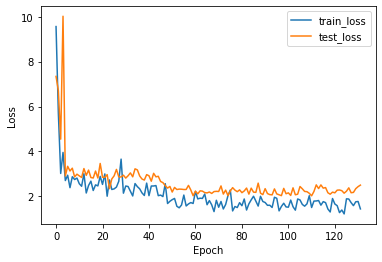

In [92]:
import seaborn as sns
losses_train_float = [float(loss.cpu().detach().numpy()) for loss in losses_train_list] 
loss_indices_train = [i for i,l in enumerate(losses_train_float)] 

losses_test_float = [float(loss.cpu().detach().numpy()) for loss in losses_test_list] 
loss_indices_test = [i for i,l in enumerate(losses_test_float)] 

plt = sns.lineplot(loss_indices_train, losses_train_float)
plt = sns.lineplot(loss_indices_test, losses_test_float)

plt.legend(labels=["train_loss","test_loss"])
plt.set(xlabel='Epoch', ylabel='Loss')

In [95]:
fig = plt.get_figure()
#fig.savefig("graphs/model_FINAL_TripletMarginLoss2_default_Distance_11Ys_131Epochs_train_test_stratified.png",dpi=300)
#torch.save(model.state_dict(), "models/model_FINAL_TripletMarginLoss2_default_Distance_11Ys_131Epochs_train_test_stratified")

In [ ]:
#generating embeddings of whole data using trained model
#the trained models are available in models folder
model2 = GCN()
model2.load_state_dict(torch.load("models/model_FINAL_TripletMarginLoss2_default_Distance_11Ys_131Epochs_train_test_stratified"))
entireloader = DataLoader(data, batch_size=128, shuffle=False)

#creating list of embeddings
embedList = []

#disabling gradient
model2.eval()

for batches in dataset:
       with torch.no_grad():
            batches.to(device)
            embed = model2(batches.x.float(), batches.edge_index, batches.batch)
            embedList.append(embed)
embedList = list(map(lambda x: x.tolist(), embedList))   


#dataframe generating
#change range of header if required
header = list(range (96))
embedDf = pd.DataFrame(columns = header)
for r in embedList:
    embedDf = pd.concat([embedDf, pd.DataFrame(r, columns = header)], ignore_index=True, sort=False)

In [ ]:
embedDf = embedDf.assign(job_name = ls_jobs)

In [ ]:
#embedDf.to_csv("data/model_FINAL_TripletMarginLoss2_default_Distance_11Ys_131Epochs_train_test_stratified.csv")